In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1/age_factor) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
C# Basics,212.548800,6.856413,16.274954,31
Azure Private DNS,509.811846,26.832202,51.861253,19
Open Source/GitHub,552.749929,92.124988,168.123325,6
RAG Project,630.335201,39.395950,106.120587,16
Azure AD Authentication,833.252203,64.096323,170.580345,13
Azure Functions + Visual Studio,859.756845,66.135142,278.313892,13
Audit Report Tracker (Sharepoint List),926.573974,84.233998,259.827440,11
Email Auth and Security,933.800329,77.816694,176.080106,12
WSL + Kali Linux,1194.851729,85.346552,366.019866,14
Azure DevOps Pipelines,1342.458430,51.633017,100.983094,26


# Histogram

sum of ages: ~45791.81


<Axes: >

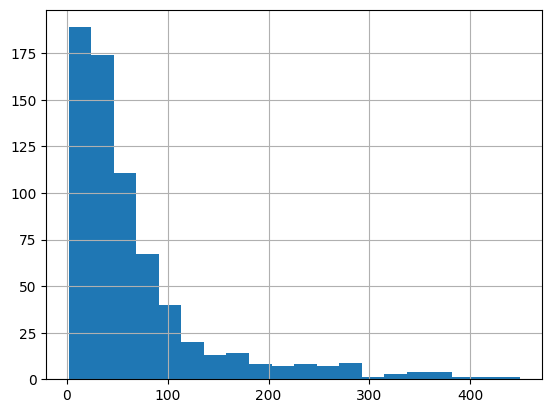

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [5]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [6]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [7]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [8]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [9]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [10]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [11]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [12]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 682
Total card age: 45791.81


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
99,Azure Developer Associate,Name two ways to visualize Azure Monitor metri...,12019d06f3f283c2eb56ccc8c9ffc6a5,-404.443317,68.904474,404.443317,-5374.548951,0.465704,0,0
100,Azure Developer Associate,What does the App Service Plan define?\nIt def...,07a261c4004dfa00978489e597ac987a,-291.567855,68.904474,404.443317,-5374.548951,0.465704,3,0
101,Azure Developer Associate,What is the recommended way to authenticate an...,d43da87d81f776dde338d920dfa09b97,-173.178348,68.904474,404.443317,-5374.548951,0.465704,6,0
102,Azure Developer Associate,Front: How can you override the account defaul...,0130f28a9791aac450a94889c2dcaada,-136.399401,68.904474,404.443317,-5374.548951,0.465704,9,0
103,Azure Developer Associate,Front: Describe the difference between Bounded...,b5a99631d7a76729cd12eb9727c92941,-119.888410,68.904474,404.443317,-5374.548951,0.465704,12,0
104,Azure Developer Associate,What is the role of Azure Monitor Connection M...,eb422c77ff49ae021290efca9e6354fb,-92.410067,68.904474,404.443317,-5374.548951,0.465704,15,0
339,Azure Developer Associate,Which Azure Monitor alert type runs a KQL quer...,5d9ccabdc8d708ea0e6a34f586e78229,-84.122361,68.904474,404.443317,-5374.548951,0.465704,18,0
106,Azure Developer Associate,Front: How does Cosmos DB decide when to split...,2b0943eb08686ef6cd2c43ebeb8b60cf,-78.778435,68.904474,404.443317,-5374.548951,0.465704,21,0
107,Azure Developer Associate,What benefit do Azure Monitor dynamic threshol...,e1041f47ab73c6f7c6a14aed43bc3fe9,-67.633805,68.904474,404.443317,-5374.548951,0.465704,24,0
341,Azure Developer Associate,Which CLI command deploys an Azure Container A...,8e4dbb0f18787d0869708060d58a81c4,-54.398141,68.904474,404.443317,-5374.548951,0.465704,27,0


## Age Mean

In [13]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [14]:
# n = 4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
## existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [15]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [16]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [17]:
existing_cards.sort_values('age').head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
151,Vocab,"Lost in a Good Book\nDoric columns: A simple, ...",7f5496b30d95587923948c9509df2835,-448.835591,56.393232,448.835591,-5018.997669,0.769329,0,0
99,Azure Developer Associate,Name two ways to visualize Azure Monitor metri...,12019d06f3f283c2eb56ccc8c9ffc6a5,-404.443317,68.904474,404.443317,-5374.548951,0.465704,0,0
27,Powershell Modules,CurrentUser Scope\n\nDefinition: An installati...,f3d0d03320782899e1352f748fc1cda5,-396.777852,95.988087,396.777852,-4223.475808,0.838548,0,0
333,Azure Developer Associate,What Azure feature should you use to securely ...,f919b56337ef29a1daaa6ec0b63377fe,-380.885500,68.904474,404.443317,-5374.548951,0.465704,1,1
42,WSL + Kali Linux,WSLg (Windows Subsystem for Linux GUI)\nA feat...,69051af876862485bdb54d8c645a8a40,-366.019866,85.346552,366.019866,-1194.851729,0.600501,0,0
130,PnP PowerShell,New-PnPList (PnP.PowerShell)\nCreates a new Sh...,9d9dc3700f5078d8eaff9507709eaacb,-365.018677,61.987934,365.018677,-3905.239831,0.361893,0,0
263,Powershell Modules,Auto-Import\n\nDefinition: A feature in PowerS...,6b1412630951dc5fee8ffa437ee0e0f2,-359.892630,95.988087,396.777852,-4223.475808,0.838548,1,1
3,Python,Q:\nWhich library is suggested for adding a pr...,20a08b1267d9ba7eb7b53e276cfdcc4c,-359.219289,100.415485,359.219289,-4719.527791,0.366986,0,0
58,JavaScript Concepts,Arrow Functions: Arrow functions provide a con...,2e3769781211a560564f81d13f2051b9,-350.905097,81.188664,350.905097,-4221.810538,0.854481,0,0
491,Powershell Modules,Get-Module\n\nDefinition: A cmdlet that retrie...,0d76065f3213ee411ee6f7e377583cc9,-346.969345,95.988087,396.777852,-4223.475808,0.838548,2,2


In [18]:
existing_cards.head(10).sum()

head                   Azure Developer AssociateAzure Developer Assoc...
body                   Name two ways to visualize Azure Monitor metri...
hash                   12019d06f3f283c2eb56ccc8c9ffc6a507a261c4004dfa...
age                                                         -1502.820139
subject_mean_age                                              689.044737
subject_highest_age                                          4044.433166
subject_age_sum                                            -53745.489513
head_random_roll                                                4.657042
count                                                                135
n_fold                                                                 0
dtype: object

In [19]:
existing_cards['age'].mean()

-67.14342250225683